# Set up

In [131]:
# import libraries 
import simfin as sf
import datetime
import random as rd
import numpy as np
import pandas as pd
import seaborn as seabornInstance 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

#set the local directory where data-files are stored
#change to your own directory
sf.set_data_dir('C:/Users/think/Desktop/UVA/2020Spring/STAT_4996_Capstone/simfin_data')

# 一个cell显示所有output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Set up API key
sf.set_api_key(api_key='free')

#display all columns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
%qtconsole

# Define Function

In [3]:
#calculate the proportion of non-missing value in each column
def prop_nonmissing(df):
    df2 = df.reset_index().copy()
    output = pd.DataFrame(index = df2.columns)
    nomiss_prop = []
    for c in df2.columns:
        nomiss_prop.append(round((1-(df2.loc[:,c].isnull().sum()/len(df2.loc[:,c])))*100,2))
    output['Prop'] = nomiss_prop
    return output

# Load in data 

In [4]:
#load in entire annual income statement data
df_income_a = sf.load_income(variant='annual', market='us').reset_index()
#load in entire annual balance sheet data 
df_balance_a = sf.load_balance(variant='annual', market='us').reset_index()
#load in entire annual balance sheet data 
df_cashflow_a = sf.load_cashflow(variant='annual', market='us').reset_index()
#load in companies detail
comp = sf.load_companies(market='us').reset_index()
industry = sf.load_industries().reset_index()

Dataset "us-income-annual" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-companies" on disk (4 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (13 days old).
- Loading from disk ... Done!


# Merging Dtat

In [5]:
comp.head(2)
industry.head(2)
comp.shape
industry.shape

,Ticker,SimFinId,Company Name,IndustryId
0,A,45846,AGILENT TECHNOLOGIES INC,106001.0
1,AA,367153,Alcoa Corp,110004.0


,IndustryId,Sector,Industry
0,100001,Industrials,Industrial Products
1,100002,Industrials,Business Services


(2067, 4)

(71, 3)

In [6]:
len(set(df_cashflow_a['Ticker']) & set(df_income_a['Ticker']))
len(set(df_cashflow_a['Ticker']) & set(df_balance_a['Ticker']))
#三个表cover的公司完全相同

1915

1915

In [7]:
#left join industry on company
comp['IndustryId'] = comp[['IndustryId']].astype('float')
df = pd.merge(comp, industry, on ='IndustryId', how = 'left',suffixes=('','_right'))
df.head(5)
df.shape

,Ticker,SimFinId,Company Name,IndustryId,Sector,Industry
0,A,45846,AGILENT TECHNOLOGIES INC,106001.0,Healthcare,Medical Diagnostics & Research
1,AA,367153,Alcoa Corp,110004.0,Basic Materials,Metals & Mining
2,AAC,939324,"AAC Holdings, Inc.",NaN,NaN,NaN
3,AAL,68568,American Airlines Group Inc.,100006.0,Industrials,Airlines
4,AAME,450021,ATLANTIC AMERICAN CORP,104004.0,Financial Services,Insurance - Life


(2067, 6)

In [8]:
#left join income statement on previous df 
df2 = pd.merge(df,df_income_a,on = ['Ticker','SimFinId'], how = 'right')

'''
#check if joined properly: missing value percentage match
prop_nonmissing(df2).sort_values(by = 'Prop',ascending = False)
df2.head(2)
df2.columns
df2.shape
'''

"\n#check if joined properly: missing value percentage match\nprop_nonmissing(df2).sort_values(by = 'Prop',ascending = False)\ndf2.head(2)\ndf2.columns\ndf2.shape\n"

In [9]:
#left join balance sheet on previous df 
df_balance_a.shape
df3 = pd.merge(df2,df_balance_a,on = ['Ticker','SimFinId','Fiscal Year','Currency'], how = 'left', suffixes=('','_b'))

'''
#take a look at the merge data
df3.head(2)
df3.columns
#check if merge successfully, if successful, the row number should not change
df2.shape
df3.shape
prop_nonmissing(df3.iloc[:,~df3.columns.isin(df2.columns)]).sort_values(by = 'Prop', ascending = False)
'''

(14768, 29)

"\n#take a look at the merge data\ndf3.head(2)\ndf3.columns\n#check if merge successfully, if successful, the row number should not change\ndf2.shape\ndf3.shape\nprop_nonmissing(df3.iloc[:,~df3.columns.isin(df2.columns)]).sort_values(by = 'Prop', ascending = False)\n"

In [10]:
#left join balance sheet on previous df 
df_cashflow_a.shape
df4 = pd.merge(df3,df_cashflow_a,on = ['Ticker','SimFinId','Fiscal Year','Currency'], how = 'left', suffixes=('','_c'))

'''
#take a look at the merge data
df4.head(2)
df4.columns
#check if merge successfully, if successful, the row number should not change
df3.shape
df4.shape
prop_nonmissing(df4.iloc[:,~df4.columns.isin(df3.columns)]).sort_values(by = 'Prop', ascending = False)
'''

(14768, 27)

"\n#take a look at the merge data\ndf4.head(2)\ndf4.columns\n#check if merge successfully, if successful, the row number should not change\ndf3.shape\ndf4.shape\nprop_nonmissing(df4.iloc[:,~df4.columns.isin(df3.columns)]).sort_values(by = 'Prop', ascending = False)\n"

In [11]:
#delete old dataframe
del df3
del df2
del df
del df_balance_a
del df_cashflow_a
del df_income_a

In [12]:
#check overlapping columns 
df4.filter(regex='_').head()
df4[['Report Date','Fiscal Period','Publish Date','Shares (Basic)','Shares (Diluted)','Depreciation & Amortization']].head()
#check if we can delete any overlapping column 
#can delete report date_b and _c
#can delete depreciation & amortizaton 
sum((df4['Report Date_b'] == df4['Report Date_c'])== False)
sum((df4['Publish Date_b'] == df4['Publish Date_c'])== False)
sum((df4['Shares (Basic)_c'] == df4['Shares (Basic)'])== False)
sum((df4['Depreciation & Amortization'] == df4['Depreciation & Amortization_c'])== False)


,Report Date_b,Fiscal Period_b,Publish Date_b,Shares (Basic)_b,Shares (Diluted)_b,Report Date_c,Fiscal Period_c,Publish Date_c,Shares (Basic)_c,Shares (Diluted)_c,Depreciation & Amortization_c
0,2008-10-31,Q4,2009-10-05,357000000.0,359000000.0,2008-10-31,FY,2009-10-05,363000000.0,371000000.0,201000000.0
1,2009-10-31,Q4,2009-12-21,343000000.0,343000000.0,2009-10-31,FY,2009-12-21,346000000.0,346000000.0,162000000.0
2,2010-10-31,Q4,2010-12-20,344000000.0,356000000.0,2010-10-31,FY,2010-12-20,347000000.0,353000000.0,202000000.0
3,2011-10-31,Q4,2011-12-16,346000000.0,353000000.0,2011-10-31,FY,2011-12-16,347000000.0,355000000.0,253000000.0
4,2012-10-31,Q4,2012-12-20,348000000.0,353000000.0,2012-10-31,FY,2012-12-20,348000000.0,353000000.0,301000000.0


,Report Date,Fiscal Period,Publish Date,Shares (Basic),Shares (Diluted),Depreciation & Amortization
0,2008-10-31,FY,2009-10-05,363000000.0,371000000.0,NaN
1,2009-10-31,FY,2009-12-21,346000000.0,346000000.0,NaN
2,2010-10-31,FY,2010-12-20,347000000.0,353000000.0,NaN
3,2011-10-31,FY,2011-12-16,347000000.0,355000000.0,NaN
4,2012-10-31,FY,2012-12-20,348000000.0,353000000.0,NaN


0

407

409

14762

In [13]:
#rearrange data frame
#drop useless columns 
df4.drop(columns=['Report Date_b','Report Date_c','Depreciation & Amortization'],inplace=True)
df4.columns

Index(['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'Report Date', 'Currency', 'Fiscal Year', 'Fiscal Period',
       'Publish Date', 'Shares (Basic)', 'Shares (Diluted)', 'Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_b', 'Publish Date_b', 'Shares (Basic)_b',
       'Shares (Diluted)_b', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Inves

In [14]:
df4.rename(columns={"Depreciation & Amortization_c": "Depreciation & Amortization"},inplace=True)
df4.columns

Index(['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'Report Date', 'Currency', 'Fiscal Year', 'Fiscal Period',
       'Publish Date', 'Shares (Basic)', 'Shares (Diluted)', 'Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_b', 'Publish Date_b', 'Shares (Basic)_b',
       'Shares (Diluted)_b', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Inves

# Filling Missing Value

## Preparation Work 

以下所有的formula已全部替换为表内对应字段名
注意
1. Stock Price 目前没有对应字段
2. 有一些标注（year-start)的字段，对应的字段名内没有“(year-start)”


| Liquidity Ratios     | Formula |
| :---- | :---- |
| Current ratio |  Total Current Assets/Total Current Liabilities       |
| Quick ratio | (Cash, Cash Equivalents & Short Term Investments+ Accounts & Notes Receivable)/Total Current Liabilities|
|Net working capital to assets ratio| (Total Current Assets-Total Current Liabilities)/Total Current Assets|
|Cash ratio| Cash, Cash Equivalents & Short Term Investments+ Accounts/Total Current Liabilities|


| Leverage Ratios     | Formula |
| :---- | :---- |
| Long-term debt ratio |  Long Term Debt/(Long Term Debt+ Total Equity) |
| Liabilities to Equity Ratio|Total Liabilities/ Total Equity)|
|Total Debt ratio|Total Liabilities/Total Assets|
| Debt to Assets Ratio|(Long Term Debt+Short Term Debt)/Total Assets|
|Interest coverage ratio|Operating Income (Loss)/Interest Expense, Net|
|Cash coverage ratio|(Operating Income (Loss)+Depreciation & Amortization)/Interest Expense, Net|


| Profitability Ratios     | Formula |
| :---- | :---- |
|After Tax Operating Income|Revenue-Operating Expenses-Depreciation & Amortization-Income Tax (Expense) Benefit, Net|
| Return on Asset |After Tax Operating Income/Total Assets  |
| Return on Capital|After Tax Operating Income/(Long Term Debt+ Total Equity)|
| Return on Equity| After Tax Operating Income/Total Equity|
| Economic Value Added| After Tax Operating Income-Cost of capital（need outside data）* (Long Term Debt+ Total Equity)|




| Efficiency Ratios     | Formula |
| :---- | :---- |
| Operating profit margin| Operating Income (Loss)/Revenue|
|Net Profit Margin| Net Income (Common)/Revenue|
|Asset Turnover|Revenue/Total Assets(year-start)|
|Receivable turover|Revenue/Accounts & Notes Receivable(year-start)|
|Inventory turnover|Cost of Revenue/Inventories(year-start)|



| Performance Ratios     | Formula |
| :---- | :---- |
| Market Value added| Stock Price * Shares (Basic) -Total Equity|
| Market to Book ratio|Stock Price * Shares (Basic)/Total Equity|
|Earning per Share|Net Income (Common)/Shares (Basic)|
|Sales per Share|Revenue/Shares (Basic)|
|Price to Earning Ratio|Stock Price/Earning Per Share|
|Price to Book Ratio|Stock Price/(Total Equity/Shares (Basic))|



In [308]:
#选取所需的column
cols1 = ['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'Report Date', 'Fiscal Year', 'Shares (Diluted)',
        'Revenue','Cost of Revenue',  'Operating Expenses',
       'Operating Income (Loss)', 'Interest Expense, Net', 
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations', 'Net Income (Common)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
        'Total Assets',  'Total Current Liabilities', 'Long Term Debt',
        'Total Liabilities', 'Total Equity', 
       'Fiscal Period_c', 'Publish Date_c', 'Net Income/Starting Line',
       'Depreciation & Amortization', 'Net Cash from Operating Activities',
        'Dividends Paid']
#columns used to calculate missing values
cols2 = [ "Pretax Income (Loss), Adj.",'Total Liabilities & Equity']
#drop rows where Industry is missing
df = df4[cols1+cols2][df4['Industry'].notnull()]
#fill dividend with 0 
df['Dividends Paid'] = df['Dividends Paid'].fillna(0)
prop_nonmissing(df).sort_values(by='Prop', ascending = False)

,Prop
index,100.00
Income (Loss) from Continuing Operations,100.00
"Pretax Income (Loss), Adj.",100.00
Dividends Paid,100.00
Net Cash from Operating Activities,100.00
Publish Date_c,100.00
Fiscal Period_c,100.00
Total Liabilities,100.00
Total Current Liabilities,100.00
Total Assets,100.00


In [209]:
#count the number of rows with no missing values. 
df.notnull().all(axis=1).sum() #6676行没missing value
#count the number of companies with no missing value
df[df.notnull().all(axis=1)]['Ticker'].nunique() #954个公司完全没有missing value

6676

954

In [243]:
#assign columns to three members 
random.seed(4996)
rand = random.sample(['Yimeng','Zhenzhen','Xinru']*5, 15)
assign = {'ratios': df.columns[df.isnull().any()], 'assignment': rand}
pd.DataFrame(assign)

,ratios,assignment
0,Shares (Diluted),Zhenzhen
1,Revenue,Zhenzhen
2,Cost of Revenue,Xinru
3,Operating Expenses,Xinru
4,Operating Income (Loss),Yimeng
5,"Interest Expense, Net",Xinru
6,"Income Tax (Expense) Benefit, Net",Zhenzhen
7,"Cash, Cash Equivalents & Short Term Investments",Xinru
8,Accounts & Notes Receivable,Xinru
9,Inventories,Zhenzhen


## Finding Correlations

### Operating Income

In [212]:
#find the columns that has correlation with Operating Income larger than 0.7
corr = df4.corr()
abs(corr[['Operating Income (Loss)']])[abs(corr['Operating Income (Loss)']) > 0.8].sort_values(by = 'Operating Income (Loss)', ascending = False )
#get those columns' names
names = abs(corr[['Operating Income (Loss)']])[abs(corr['Operating Income (Loss)']) > 0.8].sort_values(by = 'Operating Income (Loss)', ascending = False ).index.values.tolist()

#Pretax Income(Loss) has the highest correlation
#check if it has missing value in rows where Operating Income is null: 100% non-missing
df4[df4['Operating Income (Loss)'].isnull()]['Pretax Income (Loss), Adj.'].isnull().any()

,Operating Income (Loss)
Operating Income (Loss),1.000000
"Pretax Income (Loss), Adj.",0.947483
Pretax Income (Loss),0.920440
Gross Profit,0.873886
Net Cash from Operating Activities,0.869203
Income (Loss) from Continuing Operations,0.865969
Net Income/Starting Line,0.857612
Net Income,0.854496
Net Income (Common),0.854224
"Income Tax (Expense) Benefit, Net",0.816792


False

Text(0.5, 0, 'Pretax Income (Loss), Adj.')

Text(0, 0.5, 'Operating Income (Loss)')

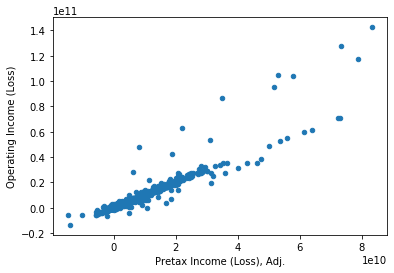

In [213]:
#check the linearity: pretty linear  
mydata = df4[["Operating Income (Loss)", "Pretax Income (Loss), Adj."]].dropna(how="any")
mydata.plot(kind= 'scatter', x="Pretax Income (Loss), Adj.", y="Operating Income (Loss)")
plt.xlabel("Pretax Income (Loss), Adj.")
plt.ylabel("Operating Income (Loss)")
plt.show()

In [276]:
#fit linear regression and use the fitted value to fill missing value
regressor = LinearRegression()  
train = df[["Pretax Income (Loss), Adj.","Operating Income (Loss)" ]][df["Operating Income (Loss)" ].notnull()]
regressor.fit(train.iloc[:,0].values.reshape(-1,1), train.iloc[:,1].values.reshape(-1,1)) #training the algorithm
predict1 =  regressor.predict(df["Pretax Income (Loss), Adj."].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

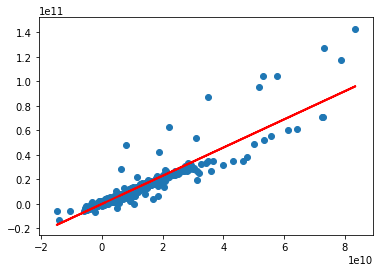

In [220]:
#check result 
plt.plot(df["Pretax Income (Loss), Adj."].values.reshape(-1,1), predict1, color='red', linewidth=2)
plt.scatter(mydata["Pretax Income (Loss), Adj."], mydata["Operating Income (Loss)"])
plt.show()

In [240]:
#assign fitted value to missing value
df.loc[df["Operating Income (Loss)"].isnull(),"Operating Income (Loss)"]=list(predict1.reshape(-1)[np.array(df["Operating Income (Loss)"].isnull())])

### Total current asset

In [257]:
#find the columns that has correlation with Operating Income larger than 0.8
abs(corr[['Total Current Assets']])[abs(corr['Total Current Assets']) > 0.8].sort_values(by = 'Total Current Assets', ascending = False )
#get those columns' names
names = abs(corr[['Total Current Assets']])[abs(corr['Total Current Assets']) > 0.8].index.values.tolist()

#check whether these column have missing value when total current asset is null
prop_nonmissing(df4[df4['Total Current Assets'].isnull()][names])
#total liabilities have the best performance, lets check for linearity

,Total Current Assets
Total Current Assets,1.000000
Research & Development,0.837776
Total Liabilities,0.810185
Total Current Liabilities,0.809414
Total Assets,0.801755
Total Liabilities & Equity,0.801754


,Prop
index,100.0
Research & Development,0.0
Total Current Assets,0.0
Total Assets,100.0
Total Current Liabilities,100.0
Total Liabilities,100.0
Total Liabilities & Equity,100.0


Text(0.5, 0, 'Total Liabilities')

Text(0, 0.5, 'Total Current Assets')

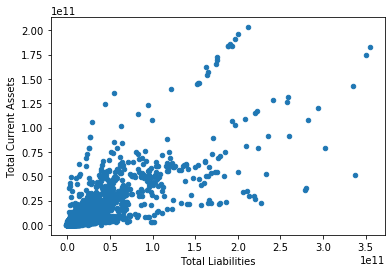

In [271]:
#check the linearity: pretty linear  
mydata = df4[['Total Current Assets', "Total Liabilities","Total Current Liabilities" ]].dropna(how="any")
mydata.plot(kind= 'scatter', x="Total Liabilities", y='Total Current Assets')
plt.xlabel("Total Liabilities")
plt.ylabel('Total Current Assets')

In [285]:
#fit linear regression and use the fitted value to fill missing value
regressor = LinearRegression()  
train = df[["Total Liabilities",'Total Current Assets']][df['Total Current Assets'].notnull()]
regressor.fit(train.iloc[:,0].values.reshape(-1,1), train.iloc[:,1].values.reshape(-1,1)) #training the algorithm
predict =  regressor.predict(df["Total Liabilities"].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

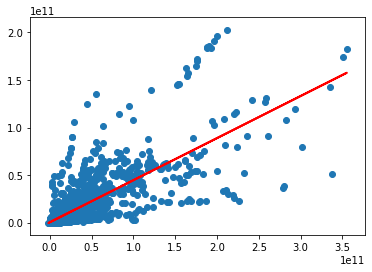

In [284]:
#check result 
plt.plot(df["Total Liabilities"].values.reshape(-1,1), predict, color='red', linewidth=2)
plt.scatter(mydata["Total Liabilities"], mydata['Total Current Assets'])
plt.show()

In [286]:
#assign fitted value to missing value
df.loc[df['Total Current Assets'].isnull(),'Total Current Assets']=list(predict.reshape(-1)[np.array(df['Total Current Assets'].isnull())])

### Total Equity

In [315]:
#we can use formula to fill 
prop_nonmissing(df4[df4['Total Equity'].isnull()][['Total Liabilities', 'Total Liabilities & Equity']])
df[df['Total Equity'].isnull()]

,Prop
index,100.0
Total Liabilities,100.0
Total Liabilities & Equity,100.0


,Ticker,SimFinId,Company Name,IndustryId,Sector,Industry,Report Date,Fiscal Year,Shares (Diluted),Revenue,Cost of Revenue,Operating Expenses,Operating Income (Loss),"Interest Expense, Net","Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income (Common),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,Total Current Assets,Total Assets,Total Current Liabilities,Long Term Debt,Total Liabilities,Total Equity,Fiscal Period_c,Publish Date_c,Net Income/Starting Line,Depreciation & Amortization,Net Cash from Operating Activities,Dividends Paid,"Pretax Income (Loss), Adj.",Total Liabilities & Equity
3165,CNNX,208611,CONE Midstream Partners LP,107003.0,Energy,Oil & Gas - Midstream,2013-12-31,2013,NaN,65626000.0,-16669000.0,-20833000.0,28124000.0,0.0,NaN,28124000,28124000,5976000.0,NaN,NaN,21148000.0,409264000,41190000,368074000.0,409264000,NaN,FY,2014-10-30,28124000.0,5825000.0,34514000,0.0,28124000,409264000


In [321]:
#这个公司不存在equity，用0fill
df.loc[df['Total Equity'].isnull(),'Total Equity'] = 0

,Ticker,SimFinId,Company Name,IndustryId,Sector,Industry,Report Date,Fiscal Year,Shares (Diluted),Revenue,Cost of Revenue,Operating Expenses,Operating Income (Loss),"Interest Expense, Net","Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income (Common),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,Total Current Assets,Total Assets,Total Current Liabilities,Long Term Debt,Total Liabilities,Total Equity,Fiscal Period_c,Publish Date_c,Net Income/Starting Line,Depreciation & Amortization,Net Cash from Operating Activities,Dividends Paid,"Pretax Income (Loss), Adj.",Total Liabilities & Equity
3165,CNNX,208611,CONE Midstream Partners LP,107003.0,Energy,Oil & Gas - Midstream,2013-12-31,2013,NaN,65626000.0,-16669000.0,-20833000.0,28124000.0,0.0,NaN,28124000,28124000,5976000.0,NaN,NaN,21148000.0,409264000,41190000,368074000.0,409264000,NaN,FY,2014-10-30,28124000.0,5825000.0,34514000,0.0,28124000,409264000
